In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as snb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [51]:
# read dataset
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")

# Data preprocessing

In [52]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [53]:
# no NaN :)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [54]:
# plt.hist(train["UniqueCarrier"], bins=train["UniqueCarrier"].unique().shape[0]);

In [55]:
rename_dict = {"dep_delayed_15min": "is_delayed"}
train.rename(columns=rename_dict, inplace=True)

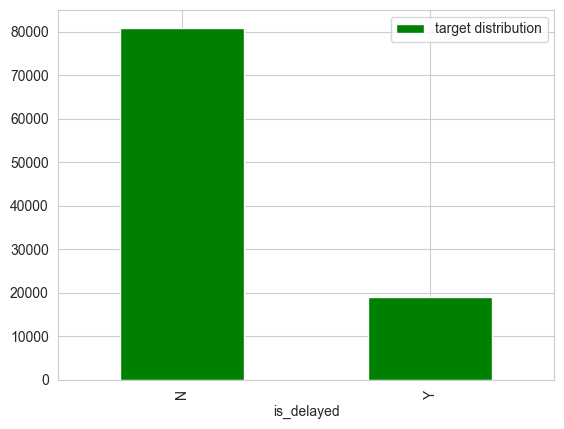

In [60]:
# target class is unbalanced -> StratifiedKFold
train["is_delayed"].value_counts().plot(kind="bar", label="target distribution", color="g")
plt.legend()

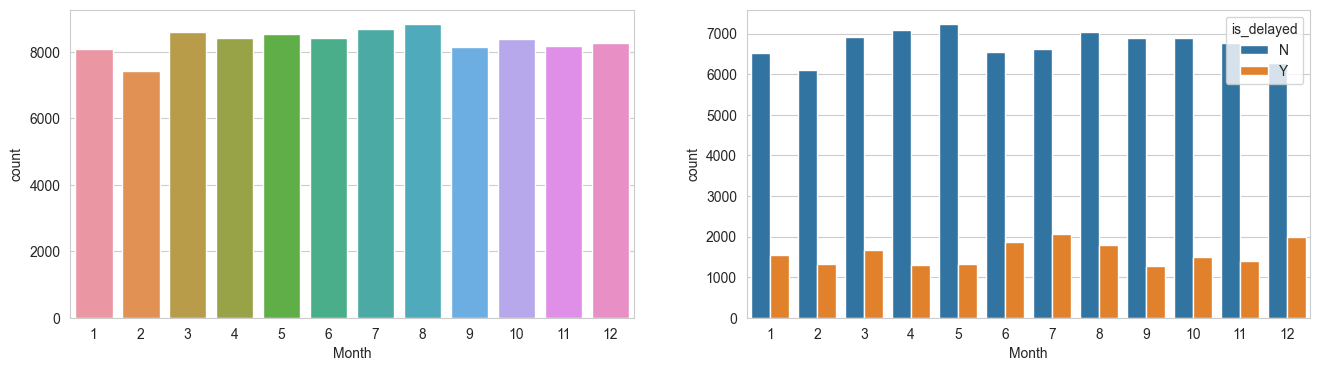

In [79]:
# slightly more delays in summer
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x="Month", ax=ax[0]);
sns.countplot(data=train, x="Month", hue="is_delayed", ax=ax[1]);

Text(0.5, 1.0, 'is_delayed by days')

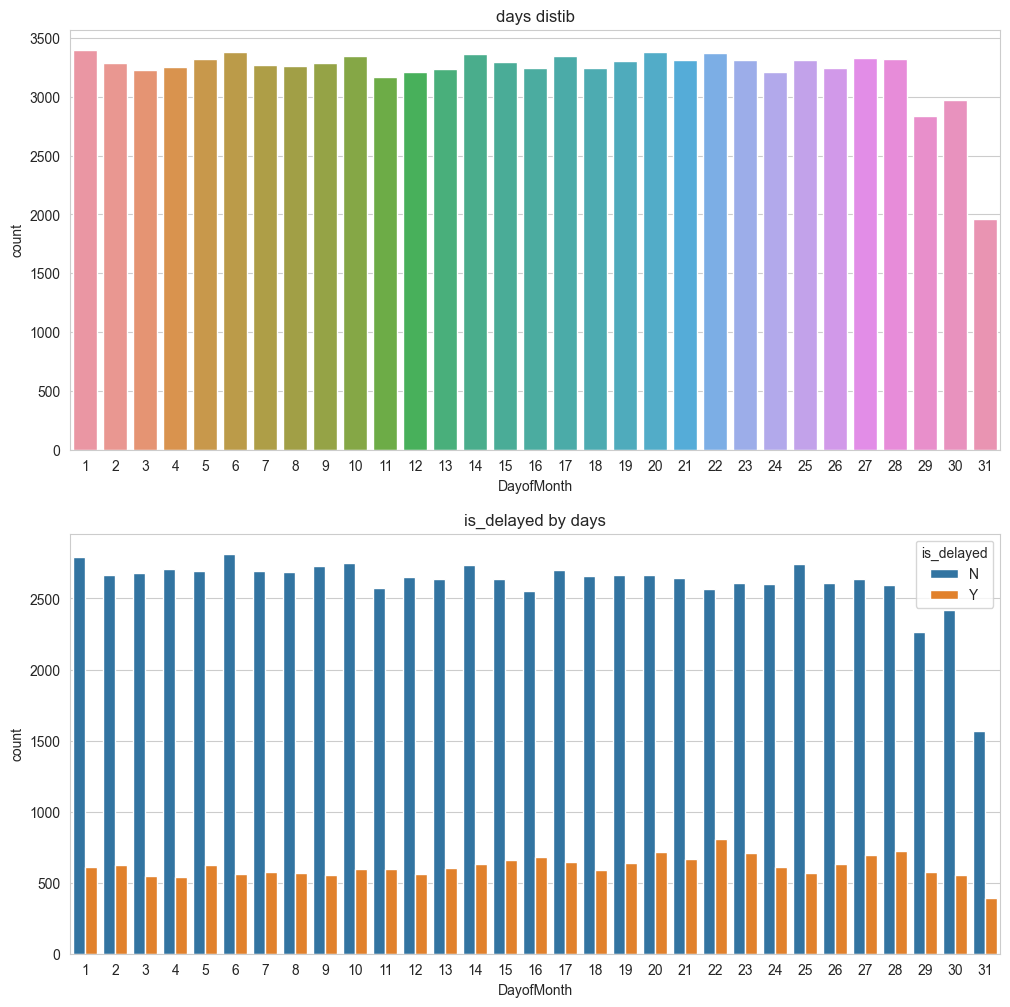

In [90]:
# there only 7 month with 31 day, so all ok
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.countplot(data=train, x="DayofMonth", ax=ax[0]);
ax[0].set_title("days distib")
sns.countplot(data=train, x="DayofMonth", hue="is_delayed", ax=ax[1]);
ax[1].set_title("is_delayed by days")

In [ ]:
sns.countplot(data=train, x="DayofMonth");

In [64]:
# convert date columns to int
for column in ["Month", 'DayofMonth', 'DayOfWeek']:
    train[column] = train[column].str.extract(r'(\d+)')
    test[column] = test[column].str.extract(r'(\d+)')
    train[column] = pd.to_numeric(train[column])
    test[column] = pd.to_numeric(test[column])

In [ ]:
# change target class labels to 0/1
train["dep_delayed_15min"] = train["dep_delayed_15min"].map({"N" : 0, "Y" : 1})

Feature engineering

In [ ]:
# add new feature -> Route = Origin + Dest
train["Route"] = train["Origin"] + "_" + train["Dest"]
test["Route"] = test["Origin"] + "_" + train["Dest"]

In [95]:
X_train, y_train = train.drop(["is_delayed"], axis=1), train["is_delayed"]

In [96]:
# categorical and numerical features
cat_features = list(X_train.columns[X_train.dtypes == "object"])
print(f"Cat_features: {cat_features}")
num_features = list(X_train.columns[X_train.dtypes != "object"])
print(f"Num_features: {num_features}")

Cat_features: ['UniqueCarrier', 'Origin', 'Dest']
Num_features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance']


In [97]:
# Pipelines for automatic preprocessing

# Standard scaler for numerical features
std_scaler = StandardScaler()
pipe_num = Pipeline([("scaler", std_scaler)])

# OHE for categorical features
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
pipe_cat = Pipeline([("encoder", one_hot_encoder)])

col_transformer = ColumnTransformer([("num", pipe_num, num_features),
                                     ("cat", pipe_cat, cat_features)])

In [ ]:
# X_train after transforming
X_train_transformed = col_transformer.fit_transform(X_train)
X_train_transformed[:5]

In [ ]:
# let's return the column names
X_train_transformed = pd.DataFrame(X_train_transformed, columns= [col.split("__")[-1] for col in col_transformer.get_feature_names_out()])
X_train_transformed.head()

In [ ]:
X_train_part, X_valid_part, y_train_part, y_valid_part = train_test_split(X_train_transformed, y_train, test_size=0.3, stratify=y_train, shuffle=True)

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import log_loss

def score(params):
    print("Params:", params)
    dtrain = xgb.DMatrix(X_train_part, y_train_part)
    dvalid = xgb.DMatrix(X_valid_part, y_valid_part)
    model = xgb.train(params, dtrain, params["num_round"])
    pred = model.predict(dvalid)
    score = roc_auc_score(y_valid_part, pred)
    print(f"Score: {score}")
    return {"loss": -score, "status": STATUS_OK}

def optimize(trials, space, max_evals=10):
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
    return best

Non learning param rare tuning

In [ ]:
space = {
    "num_round": 100,
    "learning_rate": 0.1,
    "max_depth": hp.choice("max_depth", np.arange(1, 14, dtype=int)),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
    "gamma": hp.quniform("gamma", 0.5, 1, 0.01),
    "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
    "eval_metric": "auc",
    "objective": "binary:logistic",
}

trials = Trials()
best_params = optimize(trials, space, 1)
best_params

lr tuning

In [ ]:
space_lr = {
    "num_round": 1500,
    'colsample_bytree': 0.65,
    'gamma': 0.98,
    'max_depth': 12,
    'min_child_weight': 3.0,
    'subsample': 0.9,
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "silent": 0,
    "learning_rate": hp.quniform("eta", 0.005, 0.05, 0.005),
}

trials = Trials()
best_params = optimize(trials, space_lr, max_evals=15)
best_params

In [ ]:
xgb_params_best = {
    ## Настраивались
    'colsample_bytree': 0.65,
    'gamma': 0.98,
    'max_depth': 12,
    'min_child_weight': 3.0,
    'subsample': 0.9,
    "learning_rate": 0.03,
    ## Не настраивались
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "silent": 0,
    "early_stopping_rounds": 10
}

dtrain = xgb.DMatrix(X_train_transformed, y_train)
# dtrain = xgb.DMatrix(X_train_part, y_train_part)
# dvalid = xgb.DMatrix(X_valid_part, y_valid_part)
# watchlist = [(dvalid, "valid"), (dtrain, "train")]
watchlist = [(dtrain, "train")]
boost = xgb.train(xgb_params_best, dtrain, 1500, watchlist)

linear model

In [ ]:
space_logit = {
    "penalty" : hp.choice("penalty", ["l1", "l2"]),
    "C" : hp.loguniform("C", -4 * np.log(10), 4 * np.log(10)),
    "solver" : "liblinear"
}

def score_logit(params):
    print("Params: ", params)
    lin_model = LogisticRegression(**params)
    lin_model.fit(X_train_part, y_train_part)
    pred = lin_model.predict_proba(X_valid_part)[:, 1]
    score = roc_auc_score(y_valid_part, pred)
    print(f"Score:{score}")
    return {"loss": -score, "status": STATUS_OK}

def optimize_logit(trials, space, max_evals=10):
    best = fmin(score_logit, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
    return best

In [ ]:
trials = Trials()
optimize_logit(trials, space_logit, 1)

In [ ]:
best_logit_params = {
    'C': 0.18126298865195695,
    'penalty': "l1",
    'solver' : 'liblinear'
}

let's take the weighted answer of the two models and put it all together into one model

In [ ]:
from sklearn.base import BaseEstimator

class My_Model(BaseEstimator):
    def __init__(self, w=None, logit_params=None, xgb_params=None):
        self.logit = None
        self.boost = None
        self.w = w
        self.logit_params = logit_params
        self.xgb_params = xgb_params

    def get_params(self, deep=True):
        return {"w": self.w, "logit_params" : self.logit_params, "xgb_params" : self.xgb_params}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X: np.array, y: np.array):
        dtrain = xgb.DMatrix(X, y)
        self.boost = xgb.train(self.xgb_params, dtrain, 1500)
        self.logit = LogisticRegression(**self.logit_params).fit(X, y)
        return self

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        boost_pred = self.boost.predict(dtest)
        logit_pred = self.logit.predict_proba(X)[:, 1]
        return self.w * boost_pred + (1 - self.w) * logit_pred

In [ ]:
mm = My_Model(0.9833484263607899, best_logit_params, xgb_params_best)

In [98]:
test_transformed = col_transformer.transform(test)
test_transformed = pd.DataFrame(test_transformed, columns= [col.split("__")[-1] for col in col_transformer.get_feature_names_out()])
dtest = xgb.DMatrix(test_transformed)

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
mm.fit(train_transformed, y_train)

In [ ]:
my_model_test_pred = mm.predict(test_transformed)

In [ ]:
# pd.Series(pred, name="dep_delayed_15min").to_csv(
#     "kaggle_submission.csv", index_label="id", header=True
# )